## Hyperparameters optimization for Random Forest in the case of multiclass (Sell, Hold, Buy)

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report




In [2]:
# Get underlying prices
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [3]:
target = pd.read_csv("../data/processed/target_df.csv", index_col = 0)["target_mc"]

In [4]:
target

Date
2018-01-02    1
2018-01-03    1
2018-01-04    1
2018-01-05    1
2018-01-08    1
             ..
2022-12-23    1
2022-12-26    1
2022-12-28    1
2022-12-29    1
2022-12-30    1
Name: target_mc, Length: 1253, dtype: int64

In [5]:
# Get the working dataframe
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [6]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

## Baseline Random Forest Classifier without new data

In [7]:
orig_df = ml_df[["UNDERLYING_LAST", "STRIKE", "C_LAST", "C_BID", "C_ASK", "C_IV", "C_VOLUME", "diff_date"]].copy()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(orig_df.values, target.values.flatten(), test_size=0.2, random_state=1968)

In [9]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('rf', RandomForestClassifier())])

In [10]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 25)]
# Number of features to consider at every split
max_features = [None, 'sqrt', "log2"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 20, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion = ["gini", "entropy", "log_loss"]
# Create the random grid
random_grid = {'rf__n_estimators': n_estimators,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__bootstrap': bootstrap, 
               'rf__criterion':criterion,
               }


In [11]:
n_iter = 200
verbose_level = 1
n_jobs = 4

In [12]:
# Grid search
rf_random = RandomizedSearchCV(estimator = pipe, param_distributions = random_grid, n_iter = n_iter, cv = 5, verbose=verbose_level, random_state=1968, n_jobs = n_jobs)

In [13]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(fill_value=0.0,
                                                            strategy='constant')),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=200, n_jobs=4,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__criterion': ['gini', 'entropy',
                                                          'log_loss'],
                                        'rf__max_depth': [2, 4, 6, 8, 10, 12,
                                                          14, 16, 18, 20,
                                                          None],
                                        'rf__max_features': [None, 'sqrt',
                                                             'log2'],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [10, 17, 25, 33, 41,
                                                             49, 57, 65, 73, 81,
                                                             89, 97, 105, 112,
                                                             120, 128, 136, 144,
                                                             152, 160, 168, 176,
                                                             184, 192, 200]},
                   random_state=1968, verbose=1)

In [14]:
rf_random.best_params_

{'rf__n_estimators': 73,
 'rf__min_samples_split': 5,
 'rf__min_samples_leaf': 2,
 'rf__max_features': 'sqrt',
 'rf__max_depth': 10,
 'rf__criterion': 'entropy',
 'rf__bootstrap': False}

In [15]:
pd.DataFrame.from_dict(rf_random.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__max_depth,param_rf__criterion,param_rf__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
122,0.298389,0.009701,0.010460,0.001080,73,5,2,sqrt,10,entropy,False,"{'rf__n_estimators': 73, 'rf__min_samples_spli...",0.532338,0.557214,0.580,0.580,0.590,0.567910,0.020785,1
102,0.596002,0.014195,0.021876,0.001768,168,2,4,sqrt,10,log_loss,True,"{'rf__n_estimators': 168, 'rf__min_samples_spl...",0.557214,0.552239,0.595,0.550,0.585,0.567891,0.018475,2
140,0.460342,0.021103,0.017287,0.004509,120,5,4,sqrt,12,entropy,False,"{'rf__n_estimators': 120, 'rf__min_samples_spl...",0.557214,0.552239,0.580,0.575,0.560,0.564891,0.010709,3
1,0.763011,0.016261,0.027115,0.003691,192,10,1,log2,8,entropy,True,"{'rf__n_estimators': 192, 'rf__min_samples_spl...",0.562189,0.557214,0.570,0.575,0.560,0.564881,0.006610,4
66,0.673773,0.024317,0.017388,0.001680,128,2,4,log2,14,entropy,False,"{'rf__n_estimators': 128, 'rf__min_samples_spl...",0.567164,0.537313,0.585,0.545,0.585,0.563896,0.019825,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,0.278910,0.107969,0.015567,0.006417,89,2,2,log2,2,gini,False,"{'rf__n_estimators': 89, 'rf__min_samples_spli...",0.442786,0.467662,0.465,0.410,0.475,0.452090,0.023631,196
60,0.199332,0.008784,0.010252,0.002833,73,10,1,None,2,gini,True,"{'rf__n_estimators': 73, 'rf__min_samples_spli...",0.422886,0.457711,0.465,0.425,0.485,0.451119,0.023931,197
8,0.086075,0.004084,0.003330,0.000677,25,10,4,None,2,log_loss,True,"{'rf__n_estimators': 25, 'rf__min_samples_spli...",0.398010,0.482587,0.465,0.425,0.480,0.450119,0.033211,198
15,0.297785,0.008952,0.016405,0.001730,128,2,2,sqrt,2,log_loss,False,"{'rf__n_estimators': 128, 'rf__min_samples_spl...",0.412935,0.467662,0.470,0.410,0.470,0.446119,0.028321,199


In [16]:
best_model = rf_random.best_estimator_

In [17]:
best_model.score(X_test, y_test)

0.5378486055776892

In [18]:
predictions = best_model.predict(X_test)

In [19]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.57      0.68      0.62        98
           0       0.44      0.42      0.43        64
           1       0.56      0.46      0.51        89

    accuracy                           0.54       251
   macro avg       0.53      0.52      0.52       251
weighted avg       0.54      0.54      0.53       251



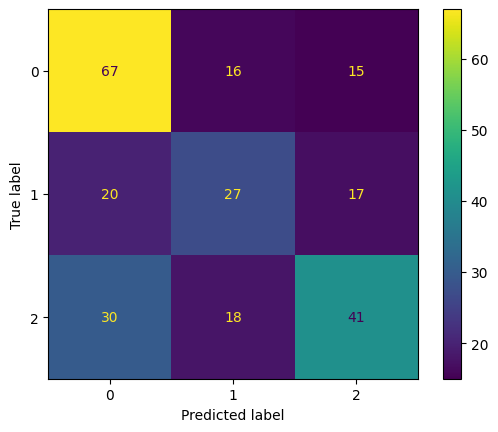

In [20]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

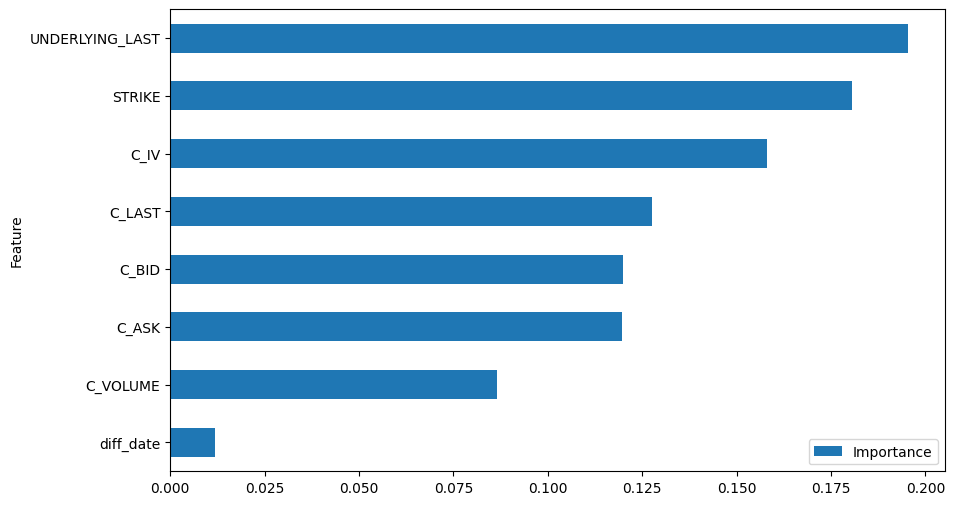

In [21]:
coefficients = best_model.named_steps["rf"].feature_importances_

feature_importance = pd.DataFrame({'Feature': orig_df.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

## Random Forest with data from MC simulation

In [22]:
new_df = pd.concat((ml_df[["UNDERLYING_LAST", "STRIKE", "C_LAST", "C_BID", "C_ASK", "C_IV", "C_VOLUME", "diff"]],wk_df.drop(["last_quote", "strike"], axis=1) ), axis=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(new_df.values, target.values.flatten(), test_size=0.2, random_state=1968)

In [24]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('rf', RandomForestClassifier())])

In [25]:
# Grid search
rf_random = RandomizedSearchCV(estimator = pipe, param_distributions = random_grid, n_iter = n_iter, cv = 5, verbose=verbose_level, random_state=1968, n_jobs = n_jobs)

In [26]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(fill_value=0.0,
                                                            strategy='constant')),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=200, n_jobs=4,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__criterion': ['gini', 'entropy',
                                                          'log_loss'],
                                        'rf__max_depth': [2, 4, 6, 8, 10, 12,
                                                          14, 16, 18, 20,
                                                          None],
                                        'rf__max_features': [None, 'sqrt',
                                                             'log2'],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [10, 17, 25, 33, 41,
                                                             49, 57, 65, 73, 81,
                                                             89, 97, 105, 112,
                                                             120, 128, 136, 144,
                                                             152, 160, 168, 176,
                                                             184, 192, 200]},
                   random_state=1968, verbose=1)

In [27]:
rf_random.best_params_

{'rf__n_estimators': 120,
 'rf__min_samples_split': 5,
 'rf__min_samples_leaf': 4,
 'rf__max_features': 'sqrt',
 'rf__max_depth': 12,
 'rf__criterion': 'entropy',
 'rf__bootstrap': False}

In [28]:
pd.DataFrame.from_dict(rf_random.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__max_depth,param_rf__criterion,param_rf__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
140,0.928437,0.023958,0.015152,0.002373,120,5,4,sqrt,12,entropy,False,"{'rf__n_estimators': 120, 'rf__min_samples_spl...",0.691542,0.651741,0.650,0.640,0.750,0.676657,0.040684,1
149,0.483012,0.011826,0.008969,0.001223,65,2,1,sqrt,10,log_loss,False,"{'rf__n_estimators': 65, 'rf__min_samples_spli...",0.691542,0.666667,0.640,0.645,0.740,0.676642,0.036550,2
25,0.784728,0.014445,0.023053,0.005366,176,10,1,sqrt,18,gini,True,"{'rf__n_estimators': 176, 'rf__min_samples_spl...",0.656716,0.651741,0.665,0.655,0.745,0.674692,0.035425,3
77,4.248048,0.079345,0.022071,0.003246,192,2,1,None,14,entropy,True,"{'rf__n_estimators': 192, 'rf__min_samples_spl...",0.701493,0.671642,0.655,0.650,0.695,0.674627,0.020676,4
175,0.852233,0.020352,0.017578,0.004001,144,5,2,log2,18,entropy,True,"{'rf__n_estimators': 144, 'rf__min_samples_spl...",0.661692,0.646766,0.675,0.645,0.740,0.673692,0.034902,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,0.343045,0.004799,0.014438,0.002620,128,2,2,sqrt,2,log_loss,False,"{'rf__n_estimators': 128, 'rf__min_samples_spl...",0.427861,0.492537,0.470,0.420,0.445,0.451080,0.026903,196
88,0.222406,0.008610,0.009299,0.001613,89,10,1,log2,2,log_loss,False,"{'rf__n_estimators': 89, 'rf__min_samples_spli...",0.427861,0.487562,0.440,0.425,0.445,0.445085,0.022496,197
74,0.255876,0.011845,0.012510,0.002467,128,10,1,sqrt,2,gini,False,"{'rf__n_estimators': 128, 'rf__min_samples_spl...",0.427861,0.487562,0.440,0.430,0.430,0.443085,0.022636,198
130,0.023098,0.000642,0.002281,0.000473,10,2,4,log2,2,gini,False,"{'rf__n_estimators': 10, 'rf__min_samples_spli...",0.422886,0.477612,0.440,0.430,0.430,0.440100,0.019532,199


In [29]:
best_model = rf_random.best_estimator_

In [30]:
best_model.score(X_test, y_test)

0.6055776892430279

In [31]:
predictions = best_model.predict(X_test)

In [32]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.66      0.76      0.70        98
           0       0.48      0.42      0.45        64
           1       0.61      0.57      0.59        89

    accuracy                           0.61       251
   macro avg       0.59      0.58      0.58       251
weighted avg       0.60      0.61      0.60       251



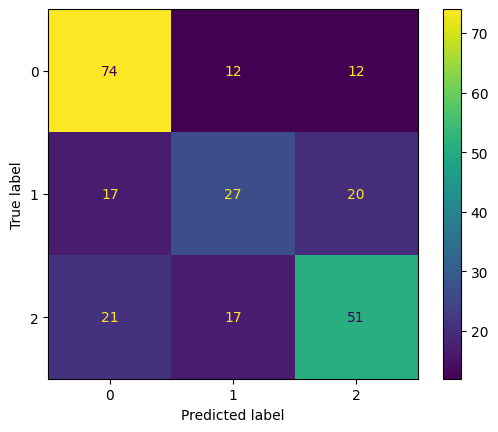

In [33]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

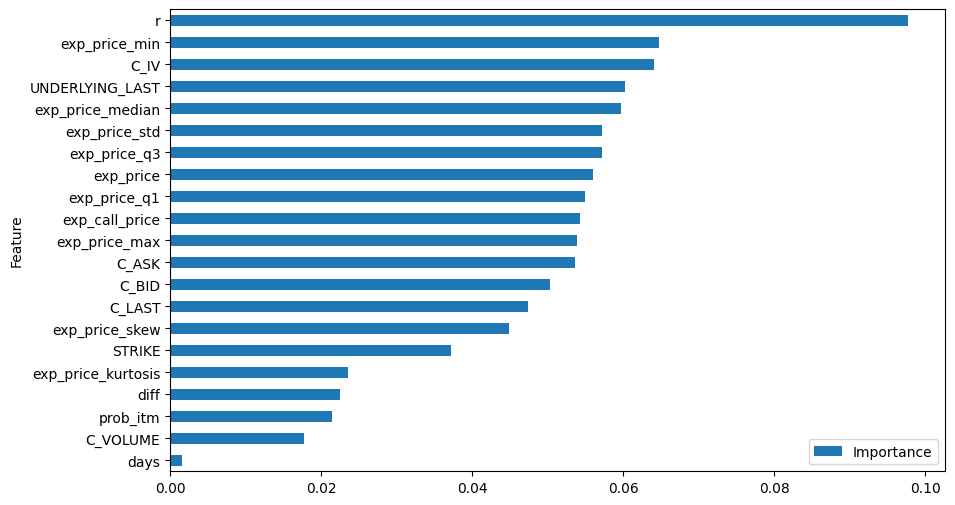

In [34]:
coefficients = best_model.named_steps["rf"].feature_importances_

feature_importance = pd.DataFrame({'Feature': new_df.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

## Random Forest with data from MC simulation and some addtional features

In [35]:
new_df = pd.concat((ml_df[["UNDERLYING_LAST", "STRIKE", "C_LAST", "C_BID", "C_ASK", "C_IV", "C_VOLUME", "diff"]],wk_df.drop(["last_quote", "strike"], axis=1) ), axis=1)

In [36]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"]-new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"]-new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"],2)
new_df["exp_profit"] = new_df["exp_price"]-(new_df["UNDERLYING_LAST"]+new_df["C_LAST"])

In [37]:
X_train, X_test, y_train, y_test = train_test_split(new_df.values, target.values.flatten(), test_size=0.2, random_state=1968)

In [38]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('rf', RandomForestClassifier())])

In [39]:
# Grid search
rf_random = RandomizedSearchCV(estimator = pipe, param_distributions = random_grid, n_iter = n_iter, cv = 5, verbose=verbose_level, random_state=1968, n_jobs = n_jobs)

In [40]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(fill_value=0.0,
                                                            strategy='constant')),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=200, n_jobs=4,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__criterion': ['gini', 'entropy',
                                                          'log_loss'],
                                        'rf__max_depth': [2, 4, 6, 8, 10, 12,
                                                          14, 16, 18, 20,
                                                          None],
                                        'rf__max_features': [None, 'sqrt',
                                                             'log2'],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [10, 17, 25, 33, 41,
                                                             49, 57, 65, 73, 81,
                                                             89, 97, 105, 112,
                                                             120, 128, 136, 144,
                                                             152, 160, 168, 176,
                                                             184, 192, 200]},
                   random_state=1968, verbose=1)

In [41]:
rf_random.best_params_

{'rf__n_estimators': 128,
 'rf__min_samples_split': 2,
 'rf__min_samples_leaf': 2,
 'rf__max_features': 'log2',
 'rf__max_depth': 14,
 'rf__criterion': 'gini',
 'rf__bootstrap': True}

In [42]:
pd.DataFrame.from_dict(rf_random.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__max_depth,param_rf__criterion,param_rf__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
124,0.559041,0.025659,0.016851,0.001537,128,2,2,log2,14,gini,True,"{'rf__n_estimators': 128, 'rf__min_samples_spl...",0.656716,0.671642,0.695,0.655,0.710,0.677672,0.021610,1
149,0.564803,0.014406,0.008939,0.003501,65,2,1,sqrt,10,log_loss,False,"{'rf__n_estimators': 65, 'rf__min_samples_spli...",0.691542,0.671642,0.645,0.640,0.730,0.675637,0.032963,2
72,1.670831,0.036512,0.028121,0.007628,200,10,1,sqrt,10,entropy,False,"{'rf__n_estimators': 200, 'rf__min_samples_spl...",0.661692,0.656716,0.650,0.655,0.745,0.673682,0.035854,3
122,0.636528,0.003489,0.010581,0.002088,73,5,2,sqrt,10,entropy,False,"{'rf__n_estimators': 73, 'rf__min_samples_spli...",0.661692,0.656716,0.660,0.665,0.725,0.673682,0.025798,3
42,0.837489,0.011815,0.020379,0.002975,160,5,1,sqrt,16,gini,True,"{'rf__n_estimators': 160, 'rf__min_samples_spl...",0.631841,0.651741,0.690,0.670,0.720,0.672716,0.030504,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,0.196119,0.007201,0.010773,0.002397,89,2,2,log2,2,gini,False,"{'rf__n_estimators': 89, 'rf__min_samples_spli...",0.427861,0.477612,0.435,0.450,0.430,0.444095,0.018456,196
15,0.388362,0.016852,0.015129,0.001612,128,2,2,sqrt,2,log_loss,False,"{'rf__n_estimators': 128, 'rf__min_samples_spl...",0.417910,0.472637,0.440,0.435,0.445,0.442109,0.017781,197
130,0.022544,0.002294,0.002168,0.000510,10,2,4,log2,2,gini,False,"{'rf__n_estimators': 10, 'rf__min_samples_spli...",0.407960,0.482587,0.440,0.445,0.425,0.440109,0.024860,198
195,0.095336,0.006886,0.005862,0.001916,41,5,1,sqrt,2,gini,False,"{'rf__n_estimators': 41, 'rf__min_samples_spli...",0.422886,0.482587,0.440,0.425,0.430,0.440095,0.022052,199


In [43]:
best_model = rf_random.best_estimator_

In [44]:
best_model.score(X_test, y_test)

0.6254980079681275

In [45]:
predictions = best_model.predict(X_test)

In [46]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.69      0.76      0.72        98
           0       0.48      0.47      0.47        64
           1       0.66      0.60      0.63        89

    accuracy                           0.63       251
   macro avg       0.61      0.61      0.61       251
weighted avg       0.62      0.63      0.62       251



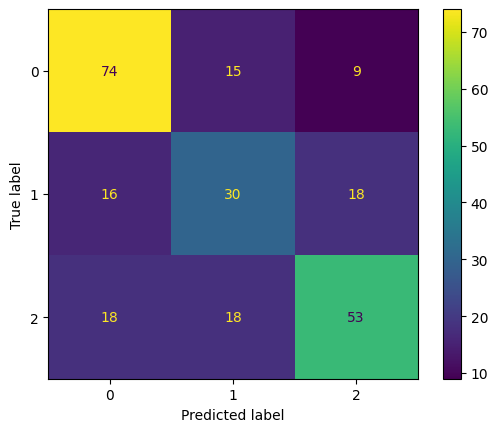

In [47]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

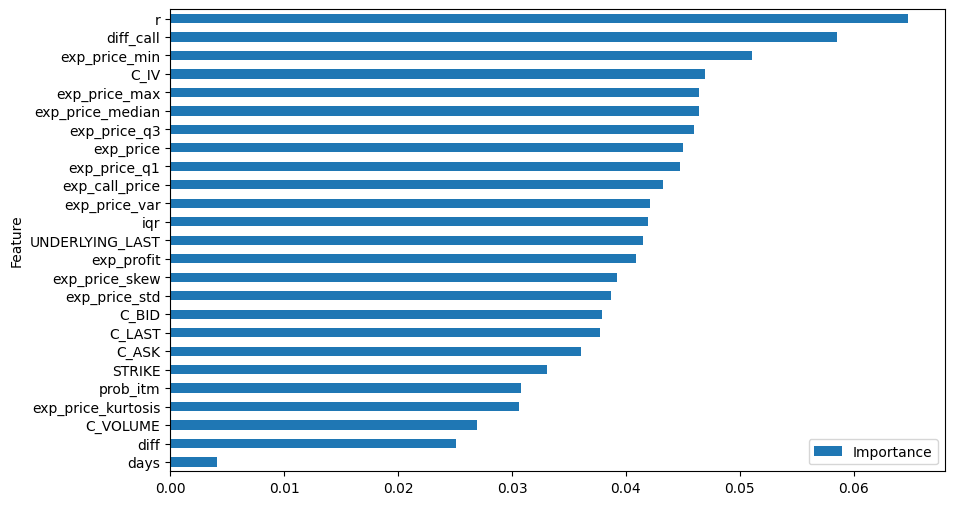

In [48]:
coefficients = best_model.named_steps["rf"].feature_importances_

feature_importance = pd.DataFrame({'Feature': new_df.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

## Classifer with orig data + r

In [72]:
# Get underlying prices
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [73]:
target = pd.read_csv("../data/processed/target_df.csv", index_col = 0)["target_mc"]

In [74]:
target

Date
2018-01-02    1
2018-01-03    1
2018-01-04    1
2018-01-05    1
2018-01-08    1
             ..
2022-12-23    1
2022-12-26    1
2022-12-28    1
2022-12-29    1
2022-12-30    1
Name: target_mc, Length: 1253, dtype: int64

In [75]:
# Get the working dataframe
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [76]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [77]:
int_rate = wk_df["r"].values

In [78]:
int_rate

array([1.28, 1.29, 1.29, ..., 3.87, 3.86, 4.04])

In [79]:
orig_df = ml_df[["UNDERLYING_LAST", "STRIKE", "C_LAST", "C_BID", "C_ASK", "C_IV", "C_VOLUME", "diff_date"]].copy()

In [80]:
# Add interest rate
orig_df["r"] = int_rate

In [81]:
X_train, X_test, y_train, y_test = train_test_split(orig_df.values, target.values.flatten(), test_size=0.2, random_state=1968)

In [82]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('rf', RandomForestClassifier())])

In [83]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 25)]
# Number of features to consider at every split
max_features = [None, 'sqrt', "log2"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 20, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion = ["gini", "entropy", "log_loss"]
# Create the random grid
random_grid = {'rf__n_estimators': n_estimators,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__bootstrap': bootstrap, 
               'rf__criterion':criterion,
               }


In [84]:
n_iter = 200
verbose_level = 1
n_jobs = 4

In [85]:
# Grid search
rf_random = RandomizedSearchCV(estimator = pipe, param_distributions = random_grid, n_iter = n_iter, cv = 5, verbose=verbose_level, random_state=1968, n_jobs = n_jobs)

In [86]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(fill_value=0.0,
                                                            strategy='constant')),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=200, n_jobs=4,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__criterion': ['gini', 'entropy',
                                                          'log_loss'],
                                        'rf__max_depth': [2, 4, 6, 8, 10, 12,
                                                          14, 16, 18, 20,
                                                          None],
                                        'rf__max_features': [None, 'sqrt',
                                                             'log2'],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [10, 17, 25, 33, 41,
                                                             49, 57, 65, 73, 81,
                                                             89, 97, 105, 112,
                                                             120, 128, 136, 144,
                                                             152, 160, 168, 176,
                                                             184, 192, 200]},
                   random_state=1968, verbose=1)

In [87]:
rf_random.best_params_

{'rf__n_estimators': 97,
 'rf__min_samples_split': 2,
 'rf__min_samples_leaf': 2,
 'rf__max_features': None,
 'rf__max_depth': None,
 'rf__criterion': 'entropy',
 'rf__bootstrap': True}

In [88]:
pd.DataFrame.from_dict(rf_random.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__max_depth,param_rf__criterion,param_rf__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
67,0.946681,0.046804,0.018523,0.010369,97,2,2,None,None,entropy,True,"{'rf__n_estimators': 97, 'rf__min_samples_spli...",0.611940,0.626866,0.665,0.635,0.705,0.648761,0.033018,1
77,1.936840,0.035616,0.035784,0.016365,192,2,1,None,14,entropy,True,"{'rf__n_estimators': 192, 'rf__min_samples_spl...",0.626866,0.631841,0.670,0.625,0.685,0.647741,0.024857,2
47,1.250439,0.036037,0.024977,0.004555,192,10,2,None,14,gini,True,"{'rf__n_estimators': 192, 'rf__min_samples_spl...",0.606965,0.661692,0.645,0.620,0.705,0.647731,0.034389,3
163,0.439882,0.020757,0.007983,0.001716,57,10,4,None,14,entropy,True,"{'rf__n_estimators': 57, 'rf__min_samples_spli...",0.601990,0.641791,0.650,0.655,0.685,0.646756,0.026720,4
167,0.551477,0.009411,0.013976,0.002251,112,5,2,log2,12,log_loss,False,"{'rf__n_estimators': 112, 'rf__min_samples_spl...",0.631841,0.641791,0.660,0.645,0.655,0.646726,0.009935,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,0.148688,0.007879,0.009440,0.001400,89,2,2,log2,2,gini,False,"{'rf__n_estimators': 89, 'rf__min_samples_spli...",0.427861,0.467662,0.475,0.430,0.480,0.456104,0.022542,196
88,0.178123,0.011768,0.011264,0.003775,89,10,1,log2,2,log_loss,False,"{'rf__n_estimators': 89, 'rf__min_samples_spli...",0.427861,0.482587,0.460,0.425,0.465,0.452090,0.022272,197
15,0.456553,0.146317,0.019379,0.002700,128,2,2,sqrt,2,log_loss,False,"{'rf__n_estimators': 128, 'rf__min_samples_spl...",0.427861,0.482587,0.460,0.420,0.465,0.451090,0.023542,198
130,0.017227,0.003384,0.002356,0.001320,10,2,4,log2,2,gini,False,"{'rf__n_estimators': 10, 'rf__min_samples_spli...",0.437811,0.452736,0.470,0.415,0.475,0.450109,0.021936,199


In [89]:
best_model = rf_random.best_estimator_

In [90]:
best_model.score(X_test, y_test)

0.649402390438247

In [91]:
predictions = best_model.predict(X_test)

In [92]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.70      0.84      0.76        98
           0       0.50      0.52      0.51        64
           1       0.71      0.54      0.61        89

    accuracy                           0.65       251
   macro avg       0.64      0.63      0.63       251
weighted avg       0.65      0.65      0.64       251



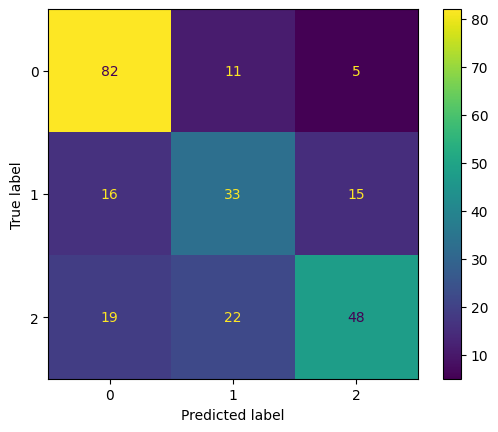

In [93]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

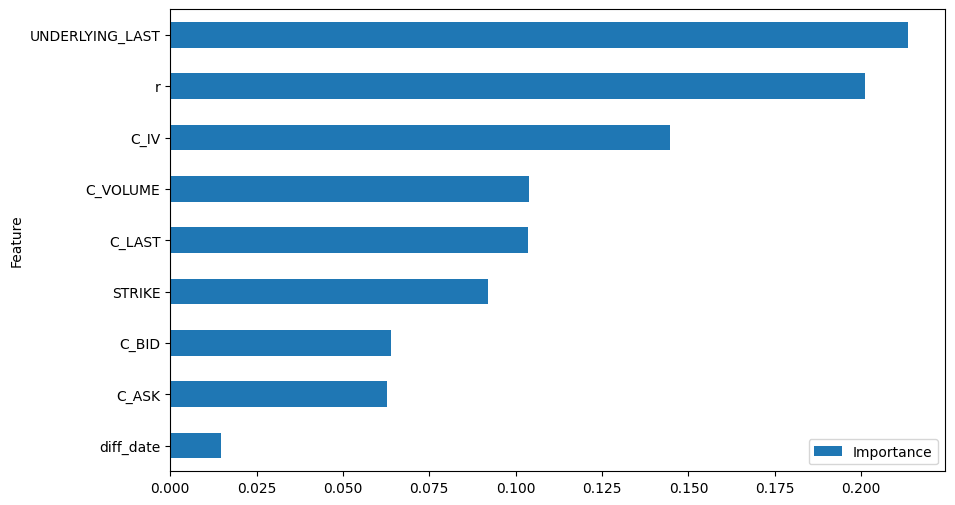

In [94]:
coefficients = best_model.named_steps["rf"].feature_importances_

feature_importance = pd.DataFrame({'Feature': orig_df.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));